# 5. CLIP

Contrastive Language-Image Pre-Training or [CLIP](https://github.com/openai/CLIP/tree/main) is a text and image encoding tool used with many popular Generative AI models such as [DALL-E](https://openai.com/dall-e-2) and [Stable Diffusion](https://github.com/Stability-AI/stablediffusion).

CLIP in itself is not a Generative AI model, but is instead used to align text encodings with image encodings. If there is such a thing as the perfect text description of an image, the goal of CLIP is to create the same vector embedding for both the image and the text. Let's see what this means in practice.

The goals of this notebook are to:
* Learn how to use CLIP Encodings
  * Get an image encoding
  * Get a text encoding
  * Calculate the cosine similarity between them
* Use CLIP to create a text-to-image neural network

## 5.1 Encodings

First, let's load the libraries needed for this exercise.

In [1]:
import csv
import glob
import numpy as np
import torch
import torch.nn.functional as F
from torch.optim import Adam
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Visualization tools
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.utils import save_image, make_grid
from textwrap import wrap

# User defined libraries
from utils import other_utils
from utils import ddpm_utils
from utils import UNet_utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

There are a few different variations of CLIP based on popular image recognition neural networks:

In [2]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

For this notebook, we will be using `ViT-B/32`, which is based on the [Vision Transformer](https://huggingface.co/docs/transformers/main/model_doc/vit) architecture. It has `512` features, which we will later feed into our diffusion model.

In [3]:
clip_model, clip_preprocess = clip.load("ViT-B/32")
clip_model.eval()
CLIP_FEATURES = 512

### 5.1.1 Image Encodings

When we load CLIP, it will also come with a set of image transformations we can use to feed images into the CLIP model:

In [4]:
clip_preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x714464d58220>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

We can test this on one of our flower photos. Let's start with a picturesque daisy.

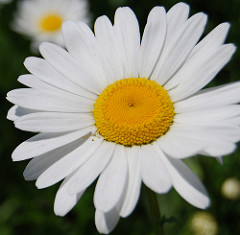

In [5]:
DATA_DIR = "data/cropped_flowers/"
img_path = DATA_DIR + "daisy/2877860110_a842f8b14a_m.jpg"
img = Image.open(img_path)
img.show()

We can find the CLIP embedding by first transforming our image with `clip_preprocess` and converting the result to a tensor. Since the `clip_model` expects a batch of images, we can use [np.stack](https://numpy.org/doc/stable/reference/generated/numpy.stack.html) to turn the processed image into a single element batch.

In [6]:
clip_imgs = torch.tensor(np.stack([clip_preprocess(img)])).to(device)
clip_imgs.size()

torch.Size([1, 3, 224, 224])

Then, we can pass the batch to `clip_model.encode_image` to find the embedding for the image. Uncomment `clip_img_encoding` if you would like to see what an encoding looks like. When we print the size, it lists `512` features for our `1` image.

In [7]:
clip_img_encoding = clip_model.encode_image(clip_imgs)
print(clip_img_encoding.size())
#clip_img_encoding

torch.Size([1, 512])


### 5.1.2 Text Encodings

Now that we have an image encoding, let's see if we can get a matching text encoding. Below is a list of different flower descriptions. Like with the images, the text needs to be preprocessed before it can be encoded by CLIP. To do this, CLIP comes with a `tokenize` function in order to convert each word into an integer.

In [8]:
text_list = [
    "A round white daisy with a yellow center",
    "An orange sunflower with a big brown center",
    "A red rose bud"
]
text_tokens = clip.tokenize(text_list).to(device)
text_tokens

tensor([[49406,   320,  2522,  1579, 12865,   593,   320,  4481,  2119, 49407,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [49406,   550,  4287, 21559,   593,   320,  1205,  2866,  2119, 49407,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0, 

Then, we can pass the tokens to `encode_text` to get our text encodings. Uncomment `clip_text_encodings` if you would like to see what an encoding looks like. Similar to our image encoding, there are `512` features for each of our `3` images.

In [9]:
clip_text_encodings = clip_model.encode_text(text_tokens).float()
print(clip_text_encodings.size())
#clip_text_encodings

torch.Size([3, 512])


### 5.1.3 Similarity

In order to see which one of our text descriptions best describes the daisy, we can calculate the [cosine similarity](https://medium.com/@milana.shxanukova15/cosine-distance-and-cosine-similarity-a5da0e4d9ded) between the text encodings and the image encodings. When the cosine similarity is `1`, it's a perfect match. When the cosine similarity is `-1`, the two encodings are opposites.

The cosine similarity is equivalent to a [dot product](https://mathworld.wolfram.com/DotProduct.html) with each vector normalized by their magnitude. In other words, the magnitude of each vector becomes `1`.

We can use the following formula to calculate the dot product:

$X \cdot Y = \sum_{i=1}^{n} x_i y_i = x_1y_1 + x_2 y_2 + \cdots  + x_n y_n$

Let's get some practice.

Try changing `x1`, `y1`, `x2`, and `y2` to a value between -`1` and `1`. When the arrows are aligned, the cosine similarity is `1`. When the arrows are pointing in opposite directions, the similarity is `-1`. 

Some values to try:

`x1, y1 = [0, 0.5]` </br>
`x2, y2 = [0, 1]`

`x1, y1 = [0, -1]` </br>
`x2, y2 = [0, 0.5]`

`x1, y1 = [1, 1]` </br>
`x2, y2 = [0, 1]`

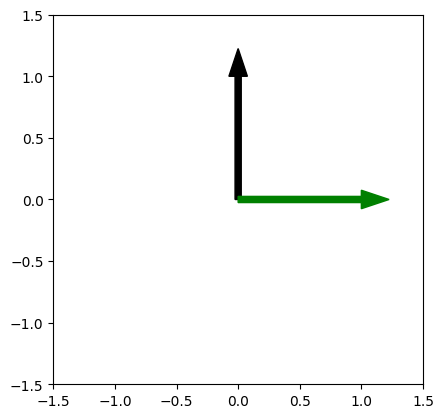

Cosine Similarity: 0.0


In [10]:
x1, y1 = [0, 1] # Change me
x2, y2 = [1, 0] # Change me

p1 = [x1, y1]
p2 = [x2, y2]

arrow_width = 0.05
plt.axis('square')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.arrow(0, 0, x1, y1, width=arrow_width, color="black")
plt.arrow(0, 0, x2, y2, width=arrow_width, color="green")
plt.show()

cosine = np.dot(p1, p2) / (np.linalg.norm(p1) * np.linalg.norm(p2))
print("Cosine Similarity:", cosine)

The cosine similarity also works with multidimensional vectors, although they are harder to plot on a 2D surface.
Try changing some of the values below. What happens when `p1` is a multiple of `p2`?

In [11]:
p1 = [1, 8, 6, 7]
p2 = [5, 3, 0, 9]

cosine = np.dot(p1, p2) / (np.linalg.norm(p1) * np.linalg.norm(p2))
print("Cosine Similarity:", cosine)

Cosine Similarity: 0.7004760286167305


Let's try calculating the similarity score for our CLIP encodings.

In [12]:
clip_img_encoding /= clip_img_encoding.norm(dim=-1, keepdim=True)
clip_text_encodings /= clip_text_encodings.norm(dim=-1, keepdim=True)
similarity = (clip_text_encodings * clip_img_encoding).sum(-1)
similarity

tensor([0.3705, 0.2471, 0.1767], device='cuda:0', grad_fn=<SumBackward1>)

What do you think? Does the most descriptive text get the highest score?

In [13]:
for idx, text in enumerate(text_list):
    print(text, " - ", similarity[idx])

A round white daisy with a yellow center  -  tensor(0.3705, device='cuda:0', grad_fn=<SelectBackward0>)
An orange sunflower with a big brown center  -  tensor(0.2471, device='cuda:0', grad_fn=<SelectBackward0>)
A red rose bud  -  tensor(0.1767, device='cuda:0', grad_fn=<SelectBackward0>)


Let's practice a little more. Below, we've added a sunflower and a rose image.

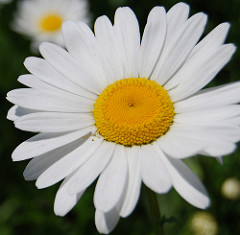

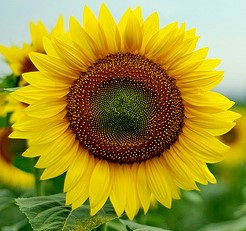

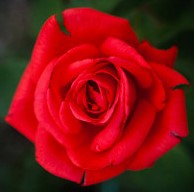

In [14]:
img_paths = [
    DATA_DIR + "daisy/2877860110_a842f8b14a_m.jpg",
    DATA_DIR + "sunflowers/2721638730_34a9b7a78b.jpg",
    DATA_DIR + "roses/8032328803_30afac8b07_m.jpg"
]

imgs = [Image.open(path) for path in img_paths]
for img in imgs:
    img.show()

**TODO**: The below `get_img_encodings` function is riddled with `FIXMEs`. Please replace each `FIXME` with the appropriate code to generate CLIP encodings from PIL images.

Click the `...` for an answer.

In [15]:
def get_img_encodings(imgs):
    processed_imgs = [clip_preprocess(img) for img in imgs]
    clip_imgs = torch.tensor(np.stack(processed_imgs)).to(device)
    clip_img_encodings = clip_model.encode_image(clip_imgs)
    return clip_img_encodings

In [16]:
def get_img_encodings(imgs):
    processed_imgs = [clip_preprocess(img) for img in imgs]
    clip_imgs = torch.tensor(np.stack(processed_imgs)).to(device)
    clip_img_encodings = clip_model.encode_image(clip_imgs)
    return clip_img_encodings

In [17]:
clip_img_encodings = get_img_encodings(imgs)
clip_img_encodings

tensor([[-0.2720, -0.0150, -0.1790,  ...,  0.5811,  0.0870, -0.1448],
        [ 0.2593, -0.1020, -0.3442,  ..., -0.0076,  0.4956,  0.0823],
        [-0.0625,  0.4141,  0.0087,  ...,  0.3274,  0.4631, -0.1396]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)

**TODO**: Find text that describes the above images well and will result in a high similarity score. After calculating the similarity score, feel free to repeat this exercise and modify. We will be using this text list again later.

Click the `...` for an example.

In [18]:
text_list = [
    "A daisy",
    "A sunflower",
    "A rose"
]

```python
text_list = [
    "A round white daisy with a yellow center",
    "An orange sunflower with a big brown center",
    "A deep red rose flower"
]
```

In [19]:
text_tokens = clip.tokenize(text_list).to(device)
clip_text_encodings = clip_model.encode_text(text_tokens).float()
clip_text_encodings

tensor([[-0.2878, -0.1921,  0.1512,  ..., -0.2296,  0.0582, -0.1426],
        [ 0.0702,  0.0190,  0.2163,  ..., -0.2566, -0.1210,  0.1396],
        [-0.2053,  0.2693,  0.2391,  ..., -0.5176, -0.0794, -0.2927]],
       device='cuda:0', grad_fn=<ToCopyBackward0>)

It would be nice to compare each combination of text and image. To do so, we can [repeat](https://pytorch.org/docs/stable/generated/torch.Tensor.repeat.html#torch.Tensor.repeat) each text encoding for each image encoding. Similarly, we can [repeat_interleave](https://pytorch.org/docs/stable/generated/torch.repeat_interleave.html) each image encoding for each text encoding.

In [20]:
clip_img_encodings /= clip_img_encodings.norm(dim=-1, keepdim=True)
clip_text_encodings /= clip_text_encodings.norm(dim=-1, keepdim=True)

n_imgs = len(imgs)
n_text = len(text_list)

In [21]:
repeated_clip_text_encodings = clip_text_encodings.repeat(n_imgs, 1)
repeated_clip_text_encodings

tensor([[-0.0296, -0.0198,  0.0156,  ..., -0.0236,  0.0060, -0.0147],
        [ 0.0074,  0.0020,  0.0227,  ..., -0.0270, -0.0127,  0.0147],
        [-0.0199,  0.0262,  0.0232,  ..., -0.0503, -0.0077, -0.0284],
        ...,
        [-0.0296, -0.0198,  0.0156,  ..., -0.0236,  0.0060, -0.0147],
        [ 0.0074,  0.0020,  0.0227,  ..., -0.0270, -0.0127,  0.0147],
        [-0.0199,  0.0262,  0.0232,  ..., -0.0503, -0.0077, -0.0284]],
       device='cuda:0', grad_fn=<RepeatBackward0>)

In [22]:
repeated_clip_img_encoding = clip_img_encodings.repeat_interleave(n_text, dim=0)
repeated_clip_img_encoding

tensor([[-0.0247, -0.0014, -0.0163,  ...,  0.0528,  0.0079, -0.0132],
        [-0.0247, -0.0014, -0.0163,  ...,  0.0528,  0.0079, -0.0132],
        [-0.0247, -0.0014, -0.0163,  ...,  0.0528,  0.0079, -0.0132],
        ...,
        [-0.0054,  0.0357,  0.0008,  ...,  0.0282,  0.0399, -0.0120],
        [-0.0054,  0.0357,  0.0008,  ...,  0.0282,  0.0399, -0.0120],
        [-0.0054,  0.0357,  0.0008,  ...,  0.0282,  0.0399, -0.0120]],
       device='cuda:0', dtype=torch.float16, grad_fn=<ViewBackward0>)

In [23]:
similarity = (repeated_clip_text_encodings * repeated_clip_img_encoding).sum(-1)
similarity = torch.unflatten(similarity, 0, (n_text, n_imgs))
similarity

tensor([[0.3260, 0.2695, 0.2329],
        [0.2556, 0.3109, 0.2079],
        [0.2163, 0.1985, 0.2938]], device='cuda:0', grad_fn=<ViewBackward0>)

Let's compare. Ideally, the diagonal from the top left to the bottom right should be a bright yellow corresponding to their high value. The rest of the values should be low and blue.

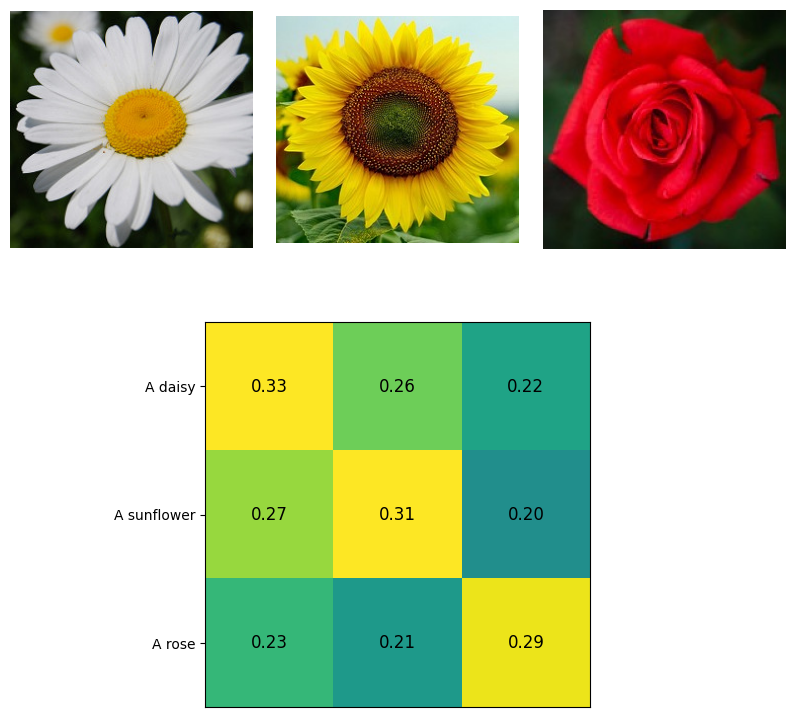

In [24]:
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(2, 3, wspace=.1, hspace=0)

for i, img in enumerate(imgs):
    ax = fig.add_subplot(gs[0, i])
    ax.axis("off")
    plt.imshow(img)

ax = fig.add_subplot(gs[1, :])
plt.imshow(similarity.detach().cpu().numpy().T, vmin=0.1, vmax=0.3)

labels = [ '\n'.join(wrap(text, 20)) for text in text_list ]
plt.yticks(range(n_text), labels, fontsize=10)
plt.xticks([])

for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[x, y]:.2f}", ha="center", va="center", size=12)

## 5.2 A CLIP Dataset

In the previous notebook, we used the flower category as the label. This time, we're going to use CLIP encodings as our label.

If the goal of CLIP is to align text encodings with image encodings, do we need a text description for each of the images in our dataset? Hypothesis: we do not need text descriptions and only need the image CLIP encodings to create a text-to-image pipeline.

To test this out, let's add the CLIP encodings as the "label" to our dataset. Running CLIP on each batch of data augmented images would be more accurate, but it is also slower. We can speed things up by preprocessing and storing the encodings ahead of time.

We can use [glob](https://docs.python.org/3/library/glob.html) to list all of our image filepaths:

In [25]:
data_paths = glob.glob(DATA_DIR + '*/*.jpg', recursive=True)
data_paths[:5]

['data/cropped_flowers/daisy/100080576_f52e8ee070_n.jpg',
 'data/cropped_flowers/daisy/10140303196_b88d3d6cec.jpg',
 'data/cropped_flowers/daisy/10172567486_2748826a8b.jpg',
 'data/cropped_flowers/daisy/10172636503_21bededa75_n.jpg',
 'data/cropped_flowers/daisy/102841525_bd6628ae3c.jpg']

The next code block runs the following loop for each filepath:
* Open the image associated with the path and store it in `img`
* Preprocess the image, find the CLIP encoding, and store it in `clip_img`
* Convert the CLIP encoding from a tensor to a python list
* Store the filepath and the CLIP encoding as a row in a csv file

In [26]:
csv_path = 'clip.csv'

with open(csv_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for idx, path in enumerate(data_paths):
        img = Image.open(path)
        clip_img = torch.tensor(np.stack([clip_preprocess(img)])).to(device)
        label = clip_model.encode_image(clip_img)[0].tolist()
        writer.writerow([path] + label)

It may take a few seconds to process the full dataset. When complete, open [clip.csv](clip.csv) to see the results.

We can use the same image transformations as we did with the other notebook:

In [27]:
IMG_SIZE = 32 # Due to stride and pooling, must be divisible by 2 multiple times
IMG_CH = 3
BATCH_SIZE = 128
INPUT_SIZE = (IMG_CH, IMG_SIZE, IMG_SIZE)

pre_transforms = [
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),  # Scales data into [0,1]
    transforms.Lambda(lambda t: (t * 2) - 1)  # Scale between [-1, 1]
]
pre_transforms = transforms.Compose(pre_transforms)
random_transforms = [
    transforms.RandomCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
]
random_transforms = transforms.Compose(random_transforms)

Below is the code to initialize our new dataset. Since we've `preprocessed_clip`, we will preload it onto our GPU with the `__init__` function. We've kept the "on the fly" CLIP encoding as an example. It will produce slightly better results, but it is much slower.

In [28]:
class MyDataset(Dataset):
    def __init__(self, csv_path, preprocessed_clip=True):
        self.imgs = []
        self.preprocessed_clip = preprocessed_clip
        if preprocessed_clip:
            self.labels = torch.empty(
                len(data_paths), CLIP_FEATURES, dtype=torch.float, device=device
            )
        
        with open(csv_path, newline='') as csvfile:
            reader = csv.reader(csvfile, delimiter=',')
            for idx, row in enumerate(reader):
                img = Image.open(row[0])
                self.imgs.append(pre_transforms(img).to(device))
                if preprocessed_clip:
                    label = [float(x) for x in row[1:]]
                    self.labels[idx, :] = torch.FloatTensor(label).to(device)

    def __getitem__(self, idx):
        img = random_transforms(self.imgs[idx])
        if self.preprocessed_clip:
            label = self.labels[idx]
        else:
            batch_img = img[None, :, :, :]
            encoded_imgs = clip_model.encode_image(clip_preprocess(batch_img))
            label = encoded_imgs.to(device).float()[0]
        return img, label

    def __len__(self):
        return len(self.imgs)

In [29]:
train_data = MyDataset(csv_path)
dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

The U-Net model is the same architecture as last time, but with one small difference. Instead of using the number of classes as our `c_embed_dim`, we will use the number of `CLIP_FEATURES`. Last time, `c` might have stood for "class", but this time, it stands for "context". Thankfully, they both start with `c`, so we do not need to refactor the code to reflect this change in intention.

In [30]:
T = 400
B_start = 0.0001
B_end = 0.02
B = torch.linspace(B_start, B_end, T).to(device)

ddpm = ddpm_utils.DDPM(B, device)
model = UNet_utils.UNet(
    T, IMG_CH, IMG_SIZE, down_chs=(256, 256, 512), t_embed_dim=8, c_embed_dim=CLIP_FEATURES
)
print("Num params: ", sum(p.numel() for p in model.parameters()))
model_flowers = torch.compile(model.to(device))

Num params:  44900355


The `get_context_mask` function will change a little bit. Since we're replacing our categorical input with a CLIP embedding, we no longer need to one-hot encode our label. We'll still randomly set values in our encoding to `0` to help the model learn without context.

In [31]:
def get_context_mask(c, drop_prob):
    c_mask = torch.bernoulli(torch.ones_like(c).float() - drop_prob).to(device)
    return c_mask

Let's also recreate the `sample_flowers` function. This time, it will take our `text_list` as a parameter and convert it to a CLIP encoding. The `sample_w` function remains mostly the same and has been moved to the bottom of [ddpm_utils.py](utils/ddpm_utils.py).

In [32]:
def sample_flowers(text_list):
    text_tokens = clip.tokenize(text_list).to(device)
    c = clip_model.encode_text(text_tokens).float()
    x_gen, x_gen_store = ddpm_utils.sample_w(model, ddpm, INPUT_SIZE, T, c, device)
    return x_gen, x_gen_store

Time to get training! After about `50` `epochs`, the model will start generating something recognizable, and at `100` it will hit its stride. What do you think? Do the generated images match your descriptions?

In [33]:
epochs=100
c_drop_prob = 0.1
lrate = 1e-4
save_dir = "05_images/"

In [35]:
optimizer = torch.optim.Adam(model.parameters(), lr=lrate)

model.train()
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()
        t = torch.randint(0, T, (BATCH_SIZE,), device=device).float()
        x, c = batch
        c_mask = get_context_mask(c, c_drop_prob)
        loss = ddpm.get_loss(model_flowers, x, t, c, c_mask)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch} | Step {step:03d} | Loss: {loss.item()}")
    if epoch % 5 == 0 or epoch == int(epochs - 1):
        x_gen, x_gen_store = sample_flowers(text_list)
        grid = make_grid(x_gen.cpu(), nrow=len(text_list))
        save_image(grid, save_dir + f"image_ep{epoch:02}.png")
        print("saved images in " + save_dir + f" for episode {epoch}")

Epoch 0 | Step 008 | Loss: 0.2606304883956909
saved images in 05_images/ for episode 0
Epoch 1 | Step 008 | Loss: 0.22318461537361145
Epoch 2 | Step 008 | Loss: 0.18445754051208496
Epoch 3 | Step 008 | Loss: 0.1890534609556198
Epoch 4 | Step 008 | Loss: 0.18343663215637207
Epoch 5 | Step 008 | Loss: 0.15036852657794952
saved images in 05_images/ for episode 5
Epoch 6 | Step 008 | Loss: 0.15513382852077484
Epoch 7 | Step 008 | Loss: 0.16687652468681335
Epoch 8 | Step 008 | Loss: 0.1356576681137085
Epoch 9 | Step 008 | Loss: 0.11169698089361191
Epoch 10 | Step 008 | Loss: 0.13255509734153748
saved images in 05_images/ for episode 10
Epoch 11 | Step 008 | Loss: 0.12913277745246887
Epoch 12 | Step 008 | Loss: 0.11345982551574707
Epoch 13 | Step 008 | Loss: 0.1603119820356369
Epoch 14 | Step 008 | Loss: 0.10702094435691833
Epoch 15 | Step 008 | Loss: 0.11861777305603027
saved images in 05_images/ for episode 15
Epoch 16 | Step 008 | Loss: 0.11968671530485153
Epoch 17 | Step 008 | Loss: 0.11

Now that the model is trained, let's play with it! What happens when we give it a prompt of something not in the dataset? Or can you craft the perfect prompt to generate an image you can imagine?

The art of crafting a prompt to get the results you desire is called **prompt engineering**, and as shown here, is dependent on the kind of data the model is trained on.

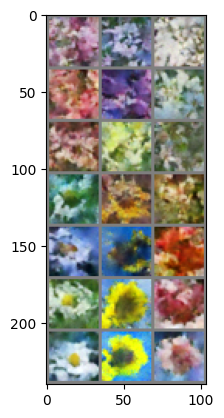

In [37]:
# Change me
text_list = [
    "A daisy",
    "A sunflower",
    "A rose"
]

model.eval()
x_gen, x_gen_store = sample_flowers(text_list)
grid = make_grid(x_gen.cpu(), nrow=len(text_list))
other_utils.show_tensor_image([grid])
plt.show()

Once you've found a set of images you enjoy, run the below cell to turn it into an animation. It will be saved to [05_images/flowers.gif](05_images/flowers.gif)

MovieWriter ffmpeg unavailable; using Pillow instead.


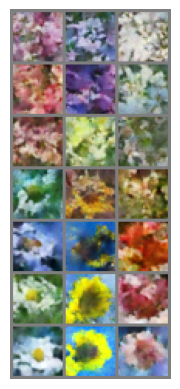

In [38]:
grids = [other_utils.to_image(make_grid(x_gen.cpu(), nrow=len(text_list))) for x_gen in x_gen_store]
other_utils.save_animation(grids, "05_images/flowers.gif")

In [39]:
# Save the model to file
model_path = "ddpm_clip_flowers.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to ddpm_clip_flowers.pth


## 5.3 Next

Congratulations on making it to the end of the course! Hope the journey was enjoyable and you were able to generate something worthy of sharing with your friends and family.

Ready to put your skills to the test?
Head on over to the assessment to earn a certificate!

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

<center><a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a></center>